In [15]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from conservative_nn.nn_lagrangian import TwoParticleNNLagrangian
from conservative_nn.nn_lagrangian_model import NNLagrangianModel
from conservative_nn.initializer import TwoParticleConstantInitializer
from conservative_nn.dynamical_system import TwoParticleSystem
from conservative_nn.monitors import (
    PositionMonitor,
    VelocityMonitor,
    InvariantMonitor,
    TwoParticleInvariantMonitor
)
from conservative_nn.trajectory_generator import TrajectoryGenerator

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load models from disk and run trajectory generators

In [33]:
from conservative_nn.monitors import VelocityMonitor


dt = 0.01
# final time
t_final = 8.0
dim_space = 4
dim = 2*dim_space
mass1=1.0
mass2=0.8
mu=1.0
kappa=1.0
# Dynamical system for exact integration
dynamical_system = TwoParticleSystem(dim_space,mass1=mass1,mass2=mass2,mu=mu,kappa=kappa)
initializer = TwoParticleConstantInitializer(dim,mass1=mass1,mass2=mass2)
perturbed_initializer = TwoParticleConstantInitializer(dim,mass1=mass1,mass2=mass2,perturbation=1.E-3)

monitors = {}
monitors_nn = {}
monitors_nn_perturbed = {}
initial_nn_linear_momentum = {}

for model_label in ["","trans","rot","rot_ref","rot_trans"]:
    # load Lagrangian from disk
    filetag = "" if model_label == "" else "_"+model_label
    model_filename = f"../assets/trained_models/two_particle/{dim_space:d}d/nn_lagrangian{filetag}/"
    nn_lagrangian = TwoParticleNNLagrangian.from_saved_model(model_filename)
    model = NNLagrangianModel(nn_lagrangian)
    dim_space = nn_lagrangian.dim_space
    dim = 2*dim_space

    # Monitors
    monitors[model_label] = [PositionMonitor(),
                             VelocityMonitor()]
    monitors_nn[model_label] = [PositionMonitor(),
                                InvariantMonitor(nn_lagrangian),
                                TwoParticleInvariantMonitor(dynamical_system)]
    monitors_nn_perturbed[model_label] = [PositionMonitor()]

    # Run trajectory generators
    trajectory_generator = TrajectoryGenerator(dynamical_system,
                                               initializer,
                                               monitors[model_label],
                                               f"../assets/trajectories/two_particle/{dim_space:d}d/exact{filetag:s}",
                                               dt=dt,t_final=t_final)
    trajectory_generator_nn = TrajectoryGenerator(model,
                                                  initializer,
                                                  monitors_nn[model_label],
                                                  f"../assets/trajectories/two_particle/{dim_space:d}d/nn{filetag:s}",
                                                  dt=dt,t_final=t_final)
    trajectory_generator_nn_perturbed = TrajectoryGenerator(model,
                                                            perturbed_initializer,
                                                            monitors_nn_perturbed[model_label],
                                                            f"../assets/trajectories/two_particle/{dim_space:d}d/nn_perturbed{filetag:s}",
                                                            dt=dt,t_final=t_final)
    trajectory_generator.run()
    trajectory_generator_nn.run()
    trajectory_generator_nn_perturbed.run()
    T = trajectory_generator.t

    # Compute NN linear momentum of first particle at initial timestep
    q0 = monitors[model_label][0].data[:,0]
    qdot0 = monitors[model_label][0].data[:,0]
    q_qdot0 = tf.reshape(np.concatenate([q0,qdot0]), shape=[1, 2 * dim])
    @tf.function
    def grad_L(inputs):
        """Compute gradient of Lagrangian with respect to inputs"""
        return tf.gradients(nn_lagrangian.call(inputs), inputs)[0]
    dL_du1 = grad_L(q_qdot0).numpy().flatten()[dim:dim+dim_space]
    initial_nn_linear_momentum[model_label] = dL_du1


## Plot (projection of) trajectories

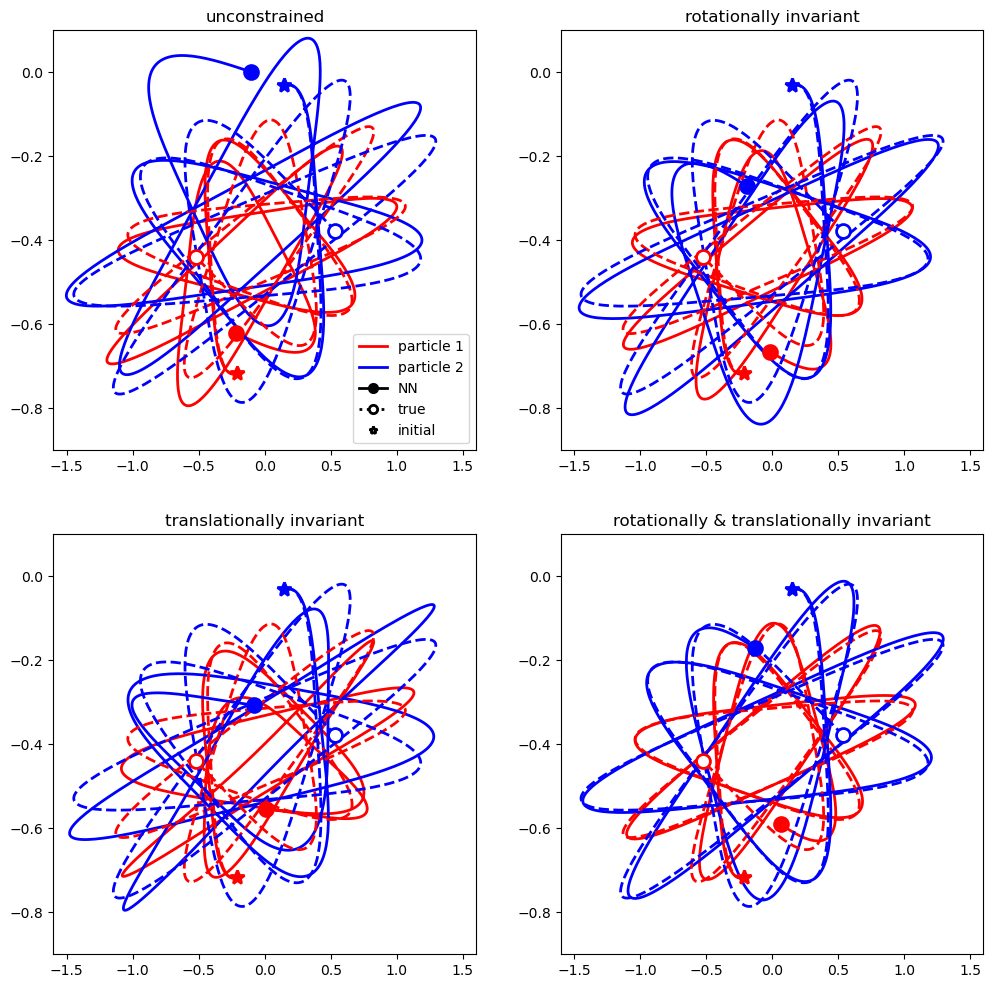

In [3]:
# Indices of space dimensions for projection
j = 0
k = 1
fs = 10

model_label_list = [["","rot"],["trans","rot_trans"]]

title = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }

fig, axs = plt.subplots(2, 2, figsize=(12,12))
for row in [0,1]:
    for col in [0,1]:
        model_label = model_label_list[row][col]
        q_all = monitors[model_label][0].data
        q_all_nn = monitors_nn[model_label][0].data
        q_all_nn_perturbed = monitors_nn_perturbed[model_label][0].data
        ax = axs[row,col]
        # Plot NN trajectories
        ax.plot(q_all_nn[j,:],q_all_nn[k,:],linewidth=2,label=f"particle 1",color="red")
        ax.plot(q_all_nn[dim_space+j,:],q_all_nn[dim_space+k,:],linewidth=2,label=f"particle 2",color="blue")
        # Plot true trajectories
        ax.plot(q_all[j,:],q_all[k,:],linewidth=2,linestyle='--',color="red")
        ax.plot(q_all[dim_space+j,:],q_all[dim_space+k,:],linewidth=2,linestyle='--',color="blue")
        # Initial positions
        ax.plot(q_all[j,0],q_all[k,0],linewidth=2,
                color="red",marker="*",markersize=10,markeredgewidth=2,markerfacecolor="red")
        ax.plot(q_all[dim_space+j,0],q_all[dim_space+k,0],linewidth=2,
                color="blue",marker="*",markersize=10,markeredgewidth=2,markerfacecolor="blue")
        # Final positions
        ax.plot(q_all_nn[j,-1],q_all_nn[k,-1],linewidth=2,
                color="red",marker="o",markersize=10,markeredgewidth=2,markerfacecolor="red")
        ax.plot(q_all_nn[dim_space+j,-1],q_all_nn[dim_space+k,-1],linewidth=2,
                color="blue",marker="o",markersize=10,markeredgewidth=2,markerfacecolor="blue")
        ax.plot(q_all[j,-1],q_all[k,-1],linewidth=2,
                color="red",marker="o",markersize=10,markeredgewidth=2,markerfacecolor="white")
        ax.plot(q_all[dim_space+j,-1],q_all[dim_space+k,-1],linewidth=2,
                color="blue",marker="o",markersize=10,markeredgewidth=2,markerfacecolor="white")
        # Additional labels
        ax.plot([],[],linewidth=2,color='black',
                marker="o",markersize=6,markeredgewidth=2,markerfacecolor="black",
                label="NN")
        ax.plot([],[],linewidth=2,linestyle=':',color='black',
                marker="o",markersize=6,markeredgewidth=2,markerfacecolor="white",
                label="true")
        ax.plot([],[],linewidth=0,color='black',
                marker="*",markersize=6,markeredgewidth=2,markerfacecolor="white",
                label="initial")
        ax.set_title(title[model_label],fontsize=12)
        if row==0 and col==0:
            ax.legend(loc="lower right",fontsize=fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.set_xlim(-1.6,1.6)
        ax.set_ylim(-0.9,0.1)
plt.savefig("trajectories_two_particle_4d.pdf",bbox_inches="tight")
plt.show()

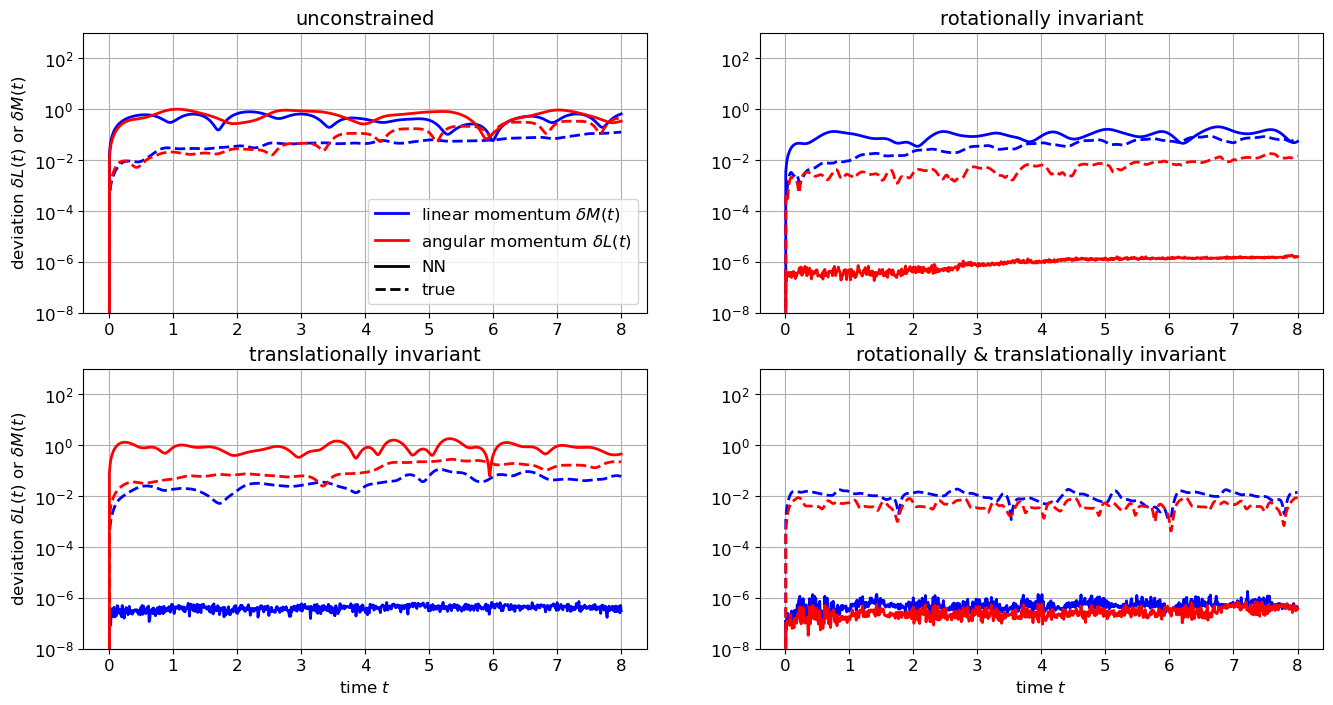

In [35]:
model_label_list = [["","rot"],["trans","rot_trans"]]
fs=12

title = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }
fig, axs = plt.subplots(2, 2, figsize=(16,8))
for row in [0,1]:
    for col in [0,1]:
        model_label = model_label_list[row][col]
        velocity = monitors[model_label][1].data
        initial_momentum = mass1*velocity[:dim_space,0]
        initial_nn_momentum = initial_nn_linear_momentum[model_label]
        invariant = monitors_nn[model_label][1].data
        invariant_true = monitors_nn[model_label][2].data
        ax = axs[row,col]        
        # Plot linear momentum

        linear_momentum = ( np.linalg.norm(invariant[:dim_space,:].T-invariant[:dim_space,0],axis=1) 
                        / np.linalg.norm(initial_nn_momentum) )
        linear_momentum_true = ( np.linalg.norm(invariant_true[:dim_space,:].T-invariant_true[:dim_space,0],axis=1) 
                        / np.linalg.norm(initial_momentum) )
        angular_momentum = ( np.linalg.norm(invariant[dim_space:,:].T-invariant[dim_space:,0],axis=1) 
                        / np.linalg.norm(invariant[dim_space:,0]) )
        angular_momentum_true = ( np.linalg.norm(invariant_true[dim_space:,:].T-invariant_true[dim_space:,0],axis=1) 
                        / np.linalg.norm(invariant_true[dim_space:,0]) )
        
        ax.plot(trajectory_generator_nn.t,linear_momentum,linewidth=2,color="blue")
        ax.plot(trajectory_generator_nn.t,linear_momentum_true,linewidth=2,linestyle="--",color="blue")
        ax.plot(trajectory_generator_nn.t,angular_momentum,linewidth=2,color="red")
        ax.plot(trajectory_generator_nn.t,angular_momentum_true,linewidth=2,linestyle="--",color="red")
        if row==0 and col==0:
            ax.plot([],[],linewidth=2,color="blue",label=r"linear momentum $\delta M(t)$")
            ax.plot([],[],linewidth=2,color="red",label=r"angular momentum $\delta L(t)$")
            ax.plot([],[],linewidth=2,color="black",label="NN")
            ax.plot([],[],linewidth=2,color="black",linestyle="--",label="true")
            ax.legend(loc="lower right",fontsize=fs)
        if row == 1:
            ax.set_xlabel("time $t$",fontsize=fs)
        if col == 0:
            ax.set_ylabel(r"deviation $\delta L(t)$ or $\delta M(t)$",fontsize=fs)
        ax.set_yscale("log")
        ax.set_ylim(1.E-8,1.E3)
        ax.set_title(title[model_label],fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.grid()
plt.savefig("invariants_two_particle_4d.pdf",bbox_inches="tight")
plt.show()

## Plot deviation between NN and true trajectories

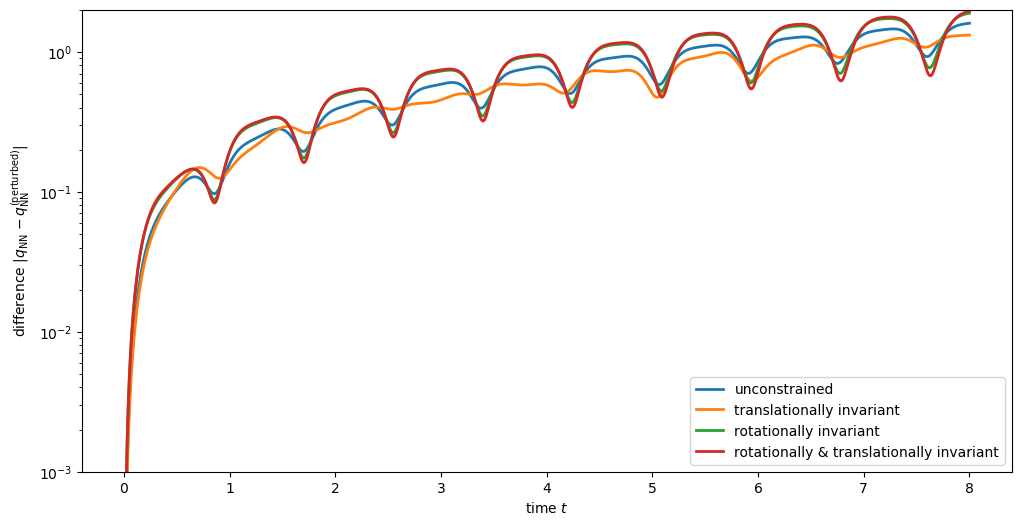

In [36]:
model_label_list = ["","trans","rot","rot_trans"]

label = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }

plt.figure(figsize=(12,6))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.E-3,2)
for model_label in model_label_list:
    q_all_nn = monitors_nn[model_label][0].data
    q_all_true = monitors[model_label][0].data
    dq = np.linalg.norm(q_all_nn[:,:]-q_all_true[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,label=label[model_label])
ax.set_xlabel("time $t$")
ax.set_ylabel(r"difference $|q_{\operatorname{NN}}-q^{(\operatorname{perturbed})}_{\operatorname{NN}}|$")
plt.legend(loc="lower right")
plt.show()

## Plot deviation between unperturbed and perturbed trajectories

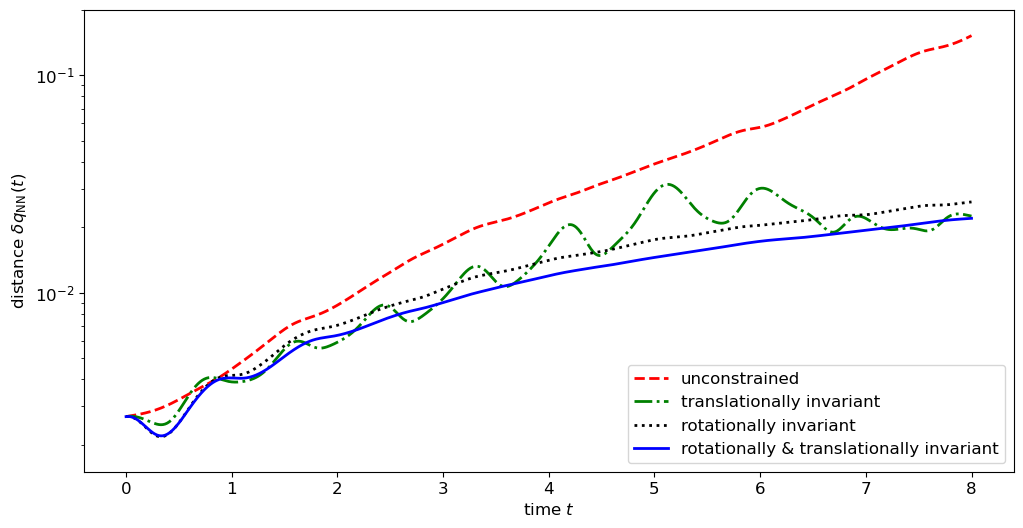

In [37]:
model_label_list = ["","trans","rot","rot_trans"]

fs=12

label = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }
color = {"":"red",
         "rot":"black",
         "trans":"green",
         "rot_trans":"blue"}
linestyle = {"":"--",
             "rot":":",
             "trans":"dashdot",
             "rot_trans":"-"}

plt.figure(figsize=(12,6))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.5E-3,0.2)
for model_label in model_label_list:
    q_all_nn = monitors_nn[model_label][0].data
    q_all_nn_perturbed = monitors_nn_perturbed[model_label][0].data
    dq = np.linalg.norm(q_all_nn[:,:]-q_all_nn_perturbed[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,
            color=color[model_label],
            linestyle=linestyle[model_label],
             label=label[model_label])
ax.set_xlabel("time $t$",fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylabel(r"distance $\delta q_{\operatorname{NN}}(t)$",fontsize=fs)
plt.legend(loc="lower right",fontsize=fs)
plt.savefig("perturbation_two_particle_4d.pdf",bbox_inches="tight")
plt.show()